In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from PIL import Image, ImageFile
from tqdm.notebook import tqdm as tqdm_notebook
from torchsummary import summary
import time
import importlib

import segmentation_loader
importlib.reload(segmentation_loader)
import autoencoder
importlib.reload(autoencoder)
from autoencoder import AutoEncoder

In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

USING_GPU = True
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.set_default_device(device)
else:
    device = torch.device("cpu")
    USING_GPU = False

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 8
TRAIN_DATASET_PATH = './data/train/'
TRAIN_MASKS_PATH = './data/annotations/stuff_train2017_pixelmaps/'
VAL_DATASET_PATH = './data/val/'
VAL_MASKS_PATH = './data/annotations/stuff_val2017_pixelmaps/'

train_ds = segmentation_loader.ImageDataset(TRAIN_DATASET_PATH, TRAIN_MASKS_PATH)
train_dl = segmentation_loader.get_loader(TRAIN_DATASET_PATH, TRAIN_MASKS_PATH, BATCH_SIZE, shuffle=False)
val_ds = segmentation_loader.ImageDataset(VAL_DATASET_PATH, VAL_MASKS_PATH)
val_dl = segmentation_loader.get_loader(VAL_DATASET_PATH, VAL_MASKS_PATH, BATCH_SIZE, shuffle=False)

In [4]:
channel_sizes = [4, 8, 16, 32]
layer_sizes = [128, 64, 32, 16]
autoencoder = AutoEncoder(layer_sizes, channel_sizes, input_size=IMAGE_SIZE).to(device)
autoencoder = autoencoder.cpu()
summary(autoencoder, (3, IMAGE_SIZE, IMAGE_SIZE), device='cpu')
autoencoder = autoencoder.to(device)

model_name = "models/autoencoder_"+"_".join([str(size) for size in layer_sizes])+".pth"
# If model already exists, load it
try:
    autoencoder.load_state_dict(torch.load(model_name))
    print("Loaded model from disk")
except:
    print("Could not load model from disk")
    pass

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 256, 256]             112
              ReLU-2          [-1, 4, 256, 256]               0
         MaxPool2d-3          [-1, 4, 128, 128]               0
            Conv2d-4          [-1, 8, 128, 128]             296
              ReLU-5          [-1, 8, 128, 128]               0
         MaxPool2d-6            [-1, 8, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]           1,168
              ReLU-8           [-1, 16, 64, 64]               0
         MaxPool2d-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]           4,640
             ReLU-11           [-1, 32, 32, 32]               0
        MaxPool2d-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 32, 16, 16]           9,248
          Flatten-14                 [-

In [5]:
def train_net(net: torch.nn.Module, train_dl: torch.utils.data.DataLoader, num_epochs: int, lr: float):
    """
    Trains the network on the given dataset
    :param net: The network to train
    :param train_dl: The dataloader for the training dataset
    :param num_epochs: The number of epochs to train for
    :param lr: The learning rate to use
    :return: None
    """
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()
    net.to(device)
    train_loss_hist = []
    val_loss_hist = []
    best_val_loss = np.inf
    # Start training
    start_time = time.time()
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        sliding_loss = 0.0
        SLIDING_WINDOW = 500
        # Training
        net.train()
        for i, (images, masks) in enumerate(tqdm_notebook(train_dl)):
            images = images.to(device)
            masks = masks.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            # Remove 2nd dimension from masks
            masks = masks.squeeze(1).long()
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            sliding_loss += loss.item() * images.size(0)
            # if i % SLIDING_WINDOW == SLIDING_WINDOW - 1:
            #     print("=========================================")
            #     print(f"Epoch progress: {i / len(train_dl) * 100:.2f}%")
            #     print(f"Time taken: {time.time() - start_time:.3f}s")
            #     print(f"Estimated time left: {(time.time() - start_time) / (i + 1) * (len(train_dl) - i - 1):.3f}s")
            #     print(f"  training loss (sliding): \t{sliding_loss / SLIDING_WINDOW:.6f}")
            #     print("=========================================")
            #     sliding_loss = 0.0
        # Validation
        net.eval()
        with torch.no_grad():
            for images, masks in tqdm_notebook(val_dl):
                images = images.to(device)
                masks = masks.to(device)
                outputs = net(images)
                # Remove 2nd dimension from masks
                masks = masks.squeeze(1).long()
                loss = loss_fn(outputs, masks.long())
                val_loss += loss.item() * images.size(0)
        train_loss_hist.append(train_loss / len(train_ds))
        val_loss_hist.append(val_loss / len(val_ds))
        print(f"Epoch {epoch + 1} of {num_epochs} done at {time.time() - start_time:.3f}s")
        print(f"  training loss (in-iteration): \t{train_loss_hist[-1]:.6f}")
        print(f"  validation loss: \t\t{val_loss_hist[-1]:.6f}")
        eta = (time.time() - start_time) / (epoch + 1) * (num_epochs - epoch - 1)
        print(f"  estimated time left: \t\t{eta:.3f}s")
        if val_loss_hist[-1] < best_val_loss:
            best_val_loss = val_loss_hist[-1]
            # Save the model
            # Name the model based on the layer sizes
            model_name = "models/autoencoder_"+"_".join([str(size) for size in layer_sizes])+".pth"
            torch.save(net.state_dict(), model_name)
    # Load back the best model
    model_name = "models/autoencoder_"+"_".join([str(size) for size in layer_sizes])+".pth"
    net.load_state_dict(torch.load(model_name))
    return train_loss_hist, val_loss_hist

In [6]:
# Set the number of epochs and learning rate
NUM_EPOCHS = 1
LEARNING_RATE = 1e-3

In [7]:
# Train the network
train_loss_hist, val_loss_hist = train_net(autoencoder, train_dl, NUM_EPOCHS, LEARNING_RATE)

  0%|          | 0/14786 [00:00<?, ?it/s]

/Users/maheshjayasankar/Documents/Style-Transfer/.venv/lib/python3.11/site-packages/torch/utils/_device.py:62: UserWarning: The operator 'aten::random_' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  return func(*args, **kwargs)


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1 of 1 done at 12544.629s
  training loss (in-iteration): 	2.212031
  validation loss: 		2.044134
  estimated time left: 		0.000s


In [8]:
# Save the model
# Name the model based on the layer sizes
model_name = "models/autoencoder_"+"_".join([str(size) for size in layer_sizes])+".pth"
torch.save(autoencoder.state_dict(), model_name)


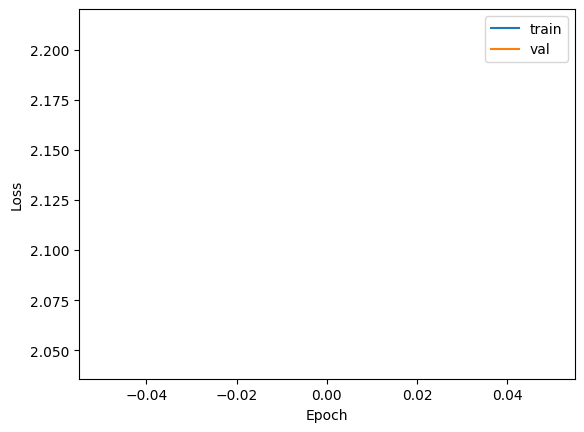

In [9]:
# Plot the loss history
plt.plot(train_loss_hist, label='train')
plt.plot(val_loss_hist, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

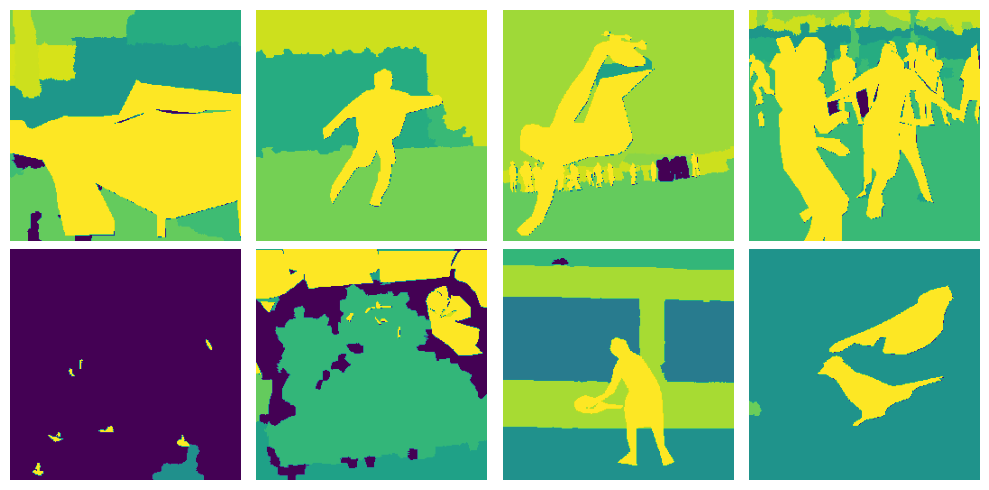

In [12]:
# Sample a few images from the train dataset
images, masks = next(iter(train_dl))

# Plot the images
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(masks[i].squeeze(0))
    ax.axis('off')
plt.tight_layout()
plt.show()

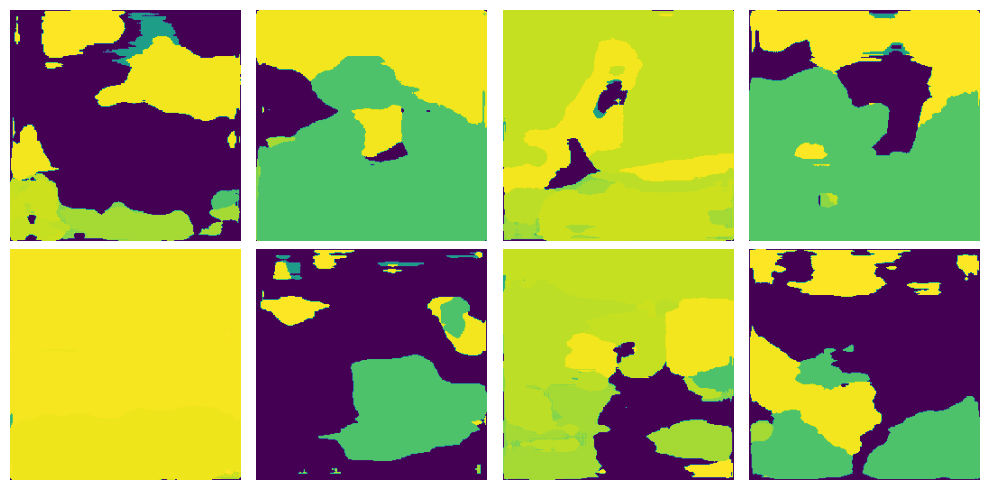

In [13]:
# Plot the reconstructed images
with torch.no_grad():
    images = images.to(device)
    outputs = autoencoder(images)
    outputs = outputs.cpu()
    # Take the argmax of the output
    outputs = torch.argmax(outputs, dim=1)
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(outputs[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

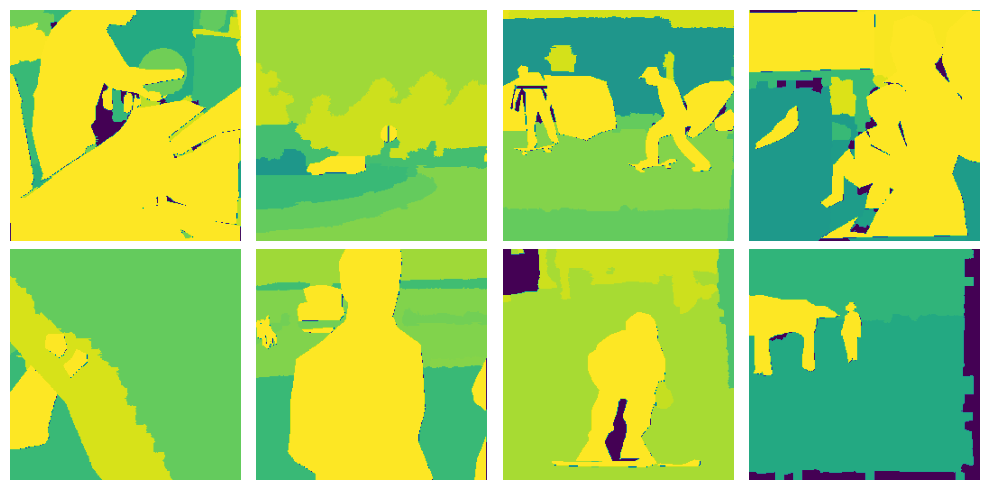

In [15]:
# Sample a few images from the validation dataset
images, masks = next(iter(val_dl))

# Plot the images
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(masks[i].squeeze(0))
    ax.axis('off')
plt.tight_layout()
plt.show()

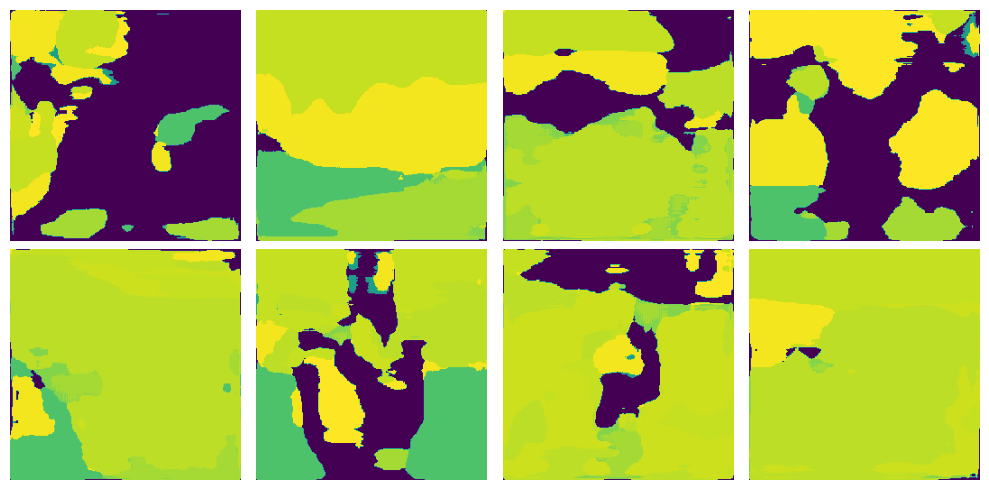

In [16]:
# Plot the reconstructed images
with torch.no_grad():
    images = images.to(device)
    outputs = autoencoder(images)
    outputs = outputs.cpu()
    # Take the argmax of the output
    outputs = torch.argmax(outputs, dim=1)
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(outputs[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()